In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb

import sklearn
# from sklearn.linear_model import *
# from sklearn.svm import SVR
from sklearn.cluster import KMeans

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
building_df = pd.read_csv('building_info.csv')

In [4]:
# print(building_df.info())

building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].replace('-', 0)
building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].replace('-', 0)
building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].replace('-', 0)

building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)

# print(building_df.info())

In [5]:
train_df = train_df.merge(building_df, on="건물번호", how="left")
test_df = test_df.merge(building_df, on="건물번호", how="left")

In [6]:
train_df.columns = ['num_date_time', 'b_num', 'D&T', 'temp', 'precip', 'w_s', 'hum',
       '일조(hr)', '일사(MJ/m2)', 'power', 'b_type', 'f_area', 'c_area',
       'SUN_light', 'ESS_save', 'PCS']
train_df.columns

test_df.columns = ['num_date_time', 'b_num', 'D&T', 'temp', 'precip', 'w_s', 'hum',
       'b_type', 'f_area', 'c_area', 'SUN_light', 'ESS_save', 'PCS']
test_df.columns

Index(['num_date_time', 'b_num', 'D&T', 'temp', 'precip', 'w_s', 'hum',
       'b_type', 'f_area', 'c_area', 'SUN_light', 'ESS_save', 'PCS'],
      dtype='object')

In [7]:
# train_df.info()
train_df.isna().sum()
# train_df.head()
# train_df.loc[train_df['hum'].isna()]
# train_df.loc[train_df['w_s'].isna()]

# 풍속 결측값
for column in train_df.columns:
    # 해당 열에서 값이 0인 위치
    zero_indices = train_df.index[train_df['w_s'].isna()]
    
    # 0인 값들을 해당 값의 앞과 뒤의 평균값으로 대체
    for idx in zero_indices:
        if idx == 0:
            # 첫 번째 행의 경우 뒤의 값
            train_df.at[idx, 'w_s'] = train_df.at[idx + 1, 'w_s']
        elif idx == len(train_df) - 1:
            # 마지막 행의 경우 앞의 값
            train_df.at[idx, 'w_s'] = train_df.at[idx - 1, 'w_s']
        else:
            # 중간 행의 경우 앞과 뒤의 값의 평균
            train_df.at[idx, 'w_s'] = (train_df.at[idx - 1, 'w_s'] + train_df.at[idx + 1, 'w_s']) / 2

# 습도 결측값
for column in train_df.columns:
    # 해당 열에서 값이 0인 위치
    zero_indices = train_df.index[train_df['hum'].isna()]
    
    # 0인 값들을 해당 값의 앞과 뒤의 평균값으로 대체
    for idx in zero_indices:
        if idx == 0:
            # 첫 번째 행의 경우 뒤의 값
            train_df.at[idx, 'hum'] = train_df.at[idx + 1, 'hum']
        elif idx == len(train_df) - 1:
            # 마지막 행의 경우 앞의 값
            train_df.at[idx, 'hum'] = train_df.at[idx - 1, 'hum']
        else:
            # 중간 행의 경우 앞과 뒤의 값의 평균
            train_df.at[idx, 'hum'] = (train_df.at[idx - 1, 'hum'] + train_df.at[idx + 1, 'hum']) / 2

# 위에서 뒤 값이 결측값이었기에 처리가 안된 나머지는 앞의 값으로 대체
train_df['w_s'].fillna(method='ffill', inplace=True)
train_df['hum'].fillna(method='ffill', inplace=True)

In [8]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# 파생변수 생성 (train data)
train_df['D&T'] = pd.to_datetime(train_df['D&T'])
train_df['hour'] = train_df['D&T'].dt.hour
train_df['sin_time'] = np.sin(2*np.pi*train_df.hour/24)
train_df['cos_time'] = np.cos(2*np.pi*train_df.hour/24)
train_df['day'] = train_df['D&T'].dt.weekday
train_df['weekend'] = train_df['day'].isin([5,6]).astype(int)
train_df['month'] = train_df['D&T'].dt.month
train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['hum']/100)*(9/5*train_df['temp']-26)+32

cdhs = np.array([])
for num in range(1,101,1):
    temp = train_df[train_df['b_num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in train_df['b_num'].unique():
    df = train_df[train_df.b_num == num]
    df = df.groupby(['day', 'hour'])['power'].mean().reset_index().pivot('day', 'hour', 'power')
    plt.subplot(20, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,100):
    ax = plt.subplot(20, 5, num)
    energy = train_df.loc[train_df.b_num == num, 'power'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

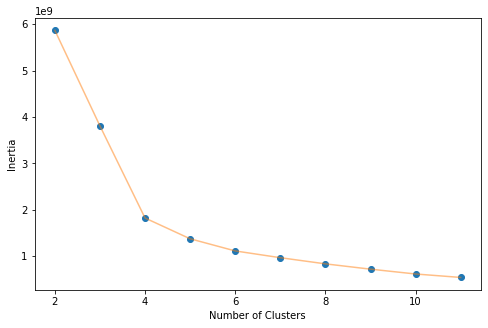

In [9]:
# K-Means > train data
by_day = train_df.groupby(['b_num','day'])['power'].median().reset_index().pivot('b_num','day','power').reset_index()
by_hour = train_df.groupby(['b_num','hour'])['power'].median().reset_index().pivot('b_num','hour','power').reset_index().drop('b_num', axis = 1)
df = pd.concat([by_day, by_hour], axis= 1)
columns = ['b_num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

# for i in range(len(df)):
#     # 요일 별 전력 중앙값에 대해 scaling
#     df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
#     # 시간대별 전력 중앙값에 대해 scaling
#     df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()
    
# fig = plt.figure(figsize = (10,3))
# for i in range(len(df)):
#     plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
# fig = plt.figure(figsize = (20,3))
# for i in range(len(df)):
#     plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [10]:
# K-Means > train data
kmeans = KMeans(n_clusters=5, random_state = 42)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
# df_clust['km_cluster'] = df_clust['km_cluster'].map({})

train_df = train_df.merge(df_clust[['b_num','km_cluster']], on='b_num', how='left')
km_d = pd.get_dummies(train_df['km_cluster'], prefix='km', drop_first=False)

train_df = pd.concat([train_df, km_d], axis=1)

In [ ]:
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [ ]:
for c in range(5):
    temp_1 = train_df[train_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5+1)+1))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.b_num == num]
        temp_2_tg = temp_2.groupby(['b_num','date','weekend'])[['power']].mean().reset_index()
        temp_2_cdh = temp_2.groupby(['b_num','date','weekend'])[['CDH']].mean().reset_index()
        temp_2 = temp_2_tg.merge(temp_2_cdh, on = ['b_num','date','weekend'], how= 'left')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='CDH', y='power', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

In [ ]:
train_df['THI_cat'] = pd.cut(train_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(5):
    temp_1 = train_df[train_df.km_cluster == c]
    nums = np.unique(temp_1.b_num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.b_num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.boxenplot(data = temp_2, x='THI', y='power', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

## Parameter Tuning

In [27]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [146]:
## gridsearchCV for best model

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
from tqdm import tqdm
import sktime

train_grid = train_df[['b_num', 'D&T', 'power', 'temp', 'w_s', 'hum', 'sin_time', 'cos_time', 'day', 'weekend', 'THI', 'CDH']]

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight', 'max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1), 
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1), 
        'subsample' : np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

smape = make_scorer(SMAPE, greater_is_better = False)
# sklearn.metrics.SCORERS.keys()
        
for i in tqdm(np.arange(1, 101)):
    y = train_grid.loc[train_grid.b_num == i, 'power']
    x = train_grid.loc[train_grid.b_num == i, ].iloc[:, 3:]
    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 0, 
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)
    
    
    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x.iloc[-168:, :])
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y.iloc[-168:], pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('hyperparameter_xgb.csv', index = False) # save the tuned parameters

xgb_params = pd.read_csv('hyperparameter_xgb.csv')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits


  1%|▊                                                                               | 1/100 [00:48<1:19:49, 48.38s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building1|| SMAPE : 23.097051042902667
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  2%|█▌                                                                              | 2/100 [01:38<1:20:42, 49.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building2|| SMAPE : 21.179248365192972
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  3%|██▍                                                                             | 3/100 [02:28<1:20:26, 49.75s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building3|| SMAPE : 18.67964057958281
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  4%|███▏                                                                            | 4/100 [02:58<1:06:51, 41.79s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building4|| SMAPE : 22.210175512229295
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  5%|████                                                                            | 5/100 [03:52<1:13:28, 46.40s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building5|| SMAPE : 22.398434533300808
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  6%|████▊                                                                           | 6/100 [04:33<1:09:35, 44.42s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building6|| SMAPE : 23.418873027254918
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  7%|█████▌                                                                          | 7/100 [05:24<1:12:14, 46.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building7|| SMAPE : 17.948915880985027
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  8%|██████▍                                                                         | 8/100 [05:51<1:01:39, 40.21s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 22.683158058528736
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  9%|███████▏                                                                        | 9/100 [06:33<1:02:01, 40.89s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building9|| SMAPE : 23.001276867943048
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 10%|████████                                                                         | 10/100 [07:02<56:02, 37.36s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 21.061667326161494
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 11%|████████▉                                                                        | 11/100 [07:27<49:41, 33.50s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building11|| SMAPE : 21.825409341309708
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 12%|█████████▋                                                                       | 12/100 [07:59<48:12, 32.87s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 23.061272094743885
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 13%|██████████▌                                                                      | 13/100 [08:26<45:08, 31.13s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building13|| SMAPE : 22.836058782963175
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 14%|███████████▎                                                                     | 14/100 [09:09<49:52, 34.79s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 19.866177039131866
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 15%|████████████▏                                                                    | 15/100 [09:38<47:03, 33.21s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building15|| SMAPE : 22.217065159053874
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 16%|████████████▉                                                                    | 16/100 [10:19<49:28, 35.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building16|| SMAPE : 21.75678222972103
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 17%|█████████████▊                                                                   | 17/100 [11:00<51:20, 37.11s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building17|| SMAPE : 23.106110790957775
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 18%|██████████████▌                                                                  | 18/100 [11:43<53:08, 38.88s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 23.8553842696305
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 19%|███████████████▍                                                                 | 19/100 [12:30<55:41, 41.26s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building19|| SMAPE : 24.241316217102124
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 20%|████████████████▏                                                                | 20/100 [13:11<55:10, 41.38s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building20|| SMAPE : 22.601465711266616
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 21%|█████████████████                                                                | 21/100 [13:50<53:19, 40.49s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building21|| SMAPE : 22.871872683194468
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 22%|█████████████████▊                                                               | 22/100 [14:20<48:32, 37.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 22.73289301466075
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 23%|██████████████████▋                                                              | 23/100 [14:47<43:59, 34.28s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 22.919078321650513
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 24%|███████████████████▍                                                             | 24/100 [15:25<44:54, 35.46s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 22.801502265796916
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 25%|████████████████████▎                                                            | 25/100 [16:03<45:17, 36.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building25|| SMAPE : 23.219364494956586
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 26%|█████████████████████                                                            | 26/100 [16:38<44:13, 35.85s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building26|| SMAPE : 22.522321644267482
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 27%|█████████████████████▊                                                           | 27/100 [17:09<41:37, 34.22s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building27|| SMAPE : 22.37279184472133
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 28%|██████████████████████▋                                                          | 28/100 [17:47<42:33, 35.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 19.99389116513329
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 29%|███████████████████████▍                                                         | 29/100 [18:20<41:10, 34.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building29|| SMAPE : 21.587841034749232
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 30%|████████████████████████▎                                                        | 30/100 [19:04<43:52, 37.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building30|| SMAPE : 22.414525989158694
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 31%|█████████████████████████                                                        | 31/100 [19:41<42:59, 37.39s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building31|| SMAPE : 21.36590273101346
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 32%|█████████████████████████▉                                                       | 32/100 [19:57<35:06, 30.97s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building32|| SMAPE : 22.355622660421805
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 33%|██████████████████████████▋                                                      | 33/100 [20:13<29:29, 26.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building33|| SMAPE : 22.683455191272305
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 34%|███████████████████████████▌                                                     | 34/100 [20:31<26:14, 23.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 22.469110429646
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 35%|████████████████████████████▎                                                    | 35/100 [20:47<23:10, 21.39s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building35|| SMAPE : 22.56436684624147
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 36%|█████████████████████████████▏                                                   | 36/100 [21:01<20:28, 19.20s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building36|| SMAPE : 22.483291527118677
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 37%|█████████████████████████████▉                                                   | 37/100 [21:44<27:54, 26.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building37|| SMAPE : 22.723940701067022
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 38%|██████████████████████████████▊                                                  | 38/100 [22:33<34:13, 33.12s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building38|| SMAPE : 22.14061250812512
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 39%|███████████████████████████████▌                                                 | 39/100 [23:18<37:12, 36.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building39|| SMAPE : 22.662004129517918
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 40%|████████████████████████████████▍                                                | 40/100 [24:11<41:45, 41.77s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building40|| SMAPE : 23.938709934570625
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 41%|█████████████████████████████████▏                                               | 41/100 [25:01<43:29, 44.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building41|| SMAPE : 23.127547970413385
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 42%|██████████████████████████████████                                               | 42/100 [25:50<44:09, 45.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building42|| SMAPE : 22.378067316565016
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 43%|██████████████████████████████████▊                                              | 43/100 [26:36<43:16, 45.55s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 20.132658915701683
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 44%|███████████████████████████████████▋                                             | 44/100 [27:18<41:34, 44.55s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building44|| SMAPE : 19.59668645049724
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 45%|████████████████████████████████████▍                                            | 45/100 [27:49<37:10, 40.56s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building45|| SMAPE : 23.505929462205113
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 46%|█████████████████████████████████████▎                                           | 46/100 [28:27<35:44, 39.71s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building46|| SMAPE : 22.880147700471888
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 47%|██████████████████████████████████████                                           | 47/100 [28:58<32:47, 37.13s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building47|| SMAPE : 21.478400261693928
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 48%|██████████████████████████████████████▉                                          | 48/100 [29:31<31:02, 35.82s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building48|| SMAPE : 23.056721409334642
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 49%|███████████████████████████████████████▋                                         | 49/100 [30:00<28:46, 33.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building49|| SMAPE : 23.923109973784292
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 50%|████████████████████████████████████████▌                                        | 50/100 [30:29<27:04, 32.49s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 22.315726858114736
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 51%|█████████████████████████████████████████▎                                       | 51/100 [31:03<26:44, 32.74s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building51|| SMAPE : 23.057273348472208
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 52%|██████████████████████████████████████████                                       | 52/100 [31:38<26:53, 33.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 23.094477595020063
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 53%|██████████████████████████████████████████▉                                      | 53/100 [32:33<31:21, 40.04s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building53|| SMAPE : 21.01057950958166
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 54%|███████████████████████████████████████████▋                                     | 54/100 [33:26<33:30, 43.70s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building54|| SMAPE : 24.304908385695718
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 55%|████████████████████████████████████████████▌                                    | 55/100 [33:46<27:25, 36.57s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 22.721887556824548
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 56%|█████████████████████████████████████████████▎                                   | 56/100 [34:04<22:55, 31.26s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 22.434771343084332
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 57%|██████████████████████████████████████████████▏                                  | 57/100 [34:51<25:47, 36.00s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building57|| SMAPE : 22.67689272119445
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 58%|██████████████████████████████████████████████▉                                  | 58/100 [35:07<20:56, 29.91s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building58|| SMAPE : 22.765632484634516
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 59%|███████████████████████████████████████████████▊                                 | 59/100 [35:57<24:32, 35.91s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building59|| SMAPE : 20.475093164886207
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 60%|████████████████████████████████████████████████▌                                | 60/100 [36:40<25:16, 37.90s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building60|| SMAPE : 22.07878309832998
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 61%|█████████████████████████████████████████████████▍                               | 61/100 [37:22<25:35, 39.37s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building61|| SMAPE : 22.558189240189844
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 62%|██████████████████████████████████████████████████▏                              | 62/100 [38:07<25:54, 40.90s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building62|| SMAPE : 21.859003676335867
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 63%|███████████████████████████████████████████████████                              | 63/100 [38:53<26:09, 42.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building63|| SMAPE : 22.168914373597072
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 64%|███████████████████████████████████████████████████▊                             | 64/100 [39:33<25:01, 41.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building64|| SMAPE : 21.40673697951537
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 65%|████████████████████████████████████████████████████▋                            | 65/100 [40:27<26:29, 45.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building65|| SMAPE : 22.088004536730622
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [40:59<23:30, 41.48s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building66|| SMAPE : 23.375447105240614
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [41:39<22:32, 40.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building67|| SMAPE : 21.192383361843927
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 68%|███████████████████████████████████████████████████████                          | 68/100 [42:20<21:53, 41.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building68|| SMAPE : 21.55037699234504
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [42:52<19:50, 38.39s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building69|| SMAPE : 22.201847190388627
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [43:37<20:06, 40.21s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building70|| SMAPE : 24.42786447224603
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [44:16<19:19, 39.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building71|| SMAPE : 23.31607898409437
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [44:43<16:46, 35.95s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building72|| SMAPE : 24.069080153379097
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [45:11<15:03, 33.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building73|| SMAPE : 22.861373706466427
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [45:50<15:13, 35.15s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building74|| SMAPE : 23.398699976641662
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [46:26<14:46, 35.44s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building75|| SMAPE : 22.532266446238904
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [46:57<13:41, 34.22s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building76|| SMAPE : 23.032810382603415
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [47:35<13:31, 35.30s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building77|| SMAPE : 22.51004440188298
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [48:19<13:54, 37.95s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building78|| SMAPE : 23.2894958318754
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [48:57<13:19, 38.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building79|| SMAPE : 22.806891753146605
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [49:48<13:55, 41.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building80|| SMAPE : 23.762642308854232
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [50:30<13:18, 42.01s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building81|| SMAPE : 21.68270513630772
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [51:22<13:25, 44.77s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building82|| SMAPE : 22.10840568637033
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [52:09<12:54, 45.58s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building83|| SMAPE : 22.734544653486388
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [52:55<12:09, 45.61s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building84|| SMAPE : 22.504362085485962
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [53:23<10:08, 40.54s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building85|| SMAPE : 23.372033838816225
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [54:09<09:47, 41.93s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building86|| SMAPE : 23.302476387429934
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [55:02<09:50, 45.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building87|| SMAPE : 23.201709699039633
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [55:53<09:25, 47.14s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building88|| SMAPE : 22.015329339128936
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [56:46<08:57, 48.90s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building89|| SMAPE : 22.039510645134428
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [57:40<08:24, 50.40s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building90|| SMAPE : 23.654485044822525
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [58:24<07:16, 48.45s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building91|| SMAPE : 23.482370640647495
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [59:07<06:13, 46.71s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building92|| SMAPE : 21.754817584175782
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [59:40<04:58, 42.71s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building93|| SMAPE : 22.13781790493991
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:00:17<04:05, 40.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building94|| SMAPE : 23.48454295671318
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:00:59<03:26, 41.21s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building95|| SMAPE : 20.137788783962197
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:01:32<02:34, 38.67s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building96|| SMAPE : 21.828615476199026
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:02:09<01:55, 38.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building97|| SMAPE : 23.990546700922984
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:02:52<01:19, 39.68s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building98|| SMAPE : 20.782683865746414
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:03:31<00:39, 39.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building99|| SMAPE : 21.85158489993226
Fitting 1 folds for each of 168 candidates, totalling 168 fits


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:04:11<00:00, 38.51s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building100|| SMAPE : 23.98557685953442


In [147]:
## best iteration

scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train_grid.loc[train_grid.b_num == i+1, 'power']
    x = train_grid.loc[train_grid.b_num == i+1, ].iloc[:, 3:]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], 
                           subsample = xgb_params.iloc[i, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

xgb_params['best_it'] = best_it

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


In [148]:
## alpha tuning

alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    y = train_grid.loc[train_grid.b_num == i+1, 'power']
    x = train_grid.loc[train_grid.b_num == i+1, ].iloc[:, 3:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
    
    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})
    
        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

xgb_params['alpha'] = alpha_list

  1%|▊                                                                                 | 1/100 [00:03<06:18,  3.83s/it]

building 1 || best score : 4.370689337926527 || alpha : 3


  2%|█▋                                                                                | 2/100 [00:07<05:52,  3.59s/it]

building 2 || best score : 5.71915929753727 || alpha : 10


  3%|██▍                                                                               | 3/100 [00:10<05:54,  3.66s/it]

building 3 || best score : 4.895329369782671 || alpha : 0


  4%|███▎                                                                              | 4/100 [00:15<06:10,  3.86s/it]

building 4 || best score : 1.8670372698297828 || alpha : 0


  5%|████                                                                              | 5/100 [00:19<06:11,  3.91s/it]

building 5 || best score : 5.242299516641663 || alpha : 7


  6%|████▉                                                                             | 6/100 [00:29<09:48,  6.26s/it]

building 6 || best score : 2.0761036600897493 || alpha : 0


  7%|█████▋                                                                            | 7/100 [00:32<07:54,  5.10s/it]

building 7 || best score : 6.172749406607514 || alpha : 1


  8%|██████▌                                                                           | 8/100 [00:38<08:07,  5.30s/it]

building 8 || best score : 2.5462412343236145 || alpha : 75


  9%|███████▍                                                                          | 9/100 [00:44<08:22,  5.52s/it]

building 9 || best score : 1.576020489810897 || alpha : 7


 10%|████████                                                                         | 10/100 [00:48<07:36,  5.07s/it]

building 10 || best score : 3.7574366354537285 || alpha : 0


 11%|████████▉                                                                        | 11/100 [00:52<07:08,  4.81s/it]

building 11 || best score : 1.724187072609042 || alpha : 5


 12%|█████████▋                                                                       | 12/100 [01:10<12:42,  8.67s/it]

building 12 || best score : 1.8091974068867214 || alpha : 100


 13%|██████████▌                                                                      | 13/100 [01:14<10:38,  7.34s/it]

building 13 || best score : 2.422971938573203 || alpha : 75


 14%|███████████▎                                                                     | 14/100 [01:17<08:27,  5.90s/it]

building 14 || best score : 8.052502528322988 || alpha : 5


 15%|████████████▏                                                                    | 15/100 [01:23<08:23,  5.92s/it]

building 15 || best score : 1.3316181812258645 || alpha : 75


 16%|████████████▉                                                                    | 16/100 [01:27<07:30,  5.36s/it]

building 16 || best score : 2.697244986329508 || alpha : 3


 17%|█████████████▊                                                                   | 17/100 [01:31<07:11,  5.20s/it]

building 17 || best score : 2.870976446425898 || alpha : 7


 18%|██████████████▌                                                                  | 18/100 [01:38<07:29,  5.48s/it]

building 18 || best score : 3.6710673409133454 || alpha : 7


 19%|███████████████▍                                                                 | 19/100 [01:43<07:27,  5.52s/it]

building 19 || best score : 4.737727072649797 || alpha : 3


 20%|████████████████▏                                                                | 20/100 [01:57<10:47,  8.09s/it]

building 20 || best score : 3.172726948320527 || alpha : 0


 21%|█████████████████                                                                | 21/100 [02:02<09:29,  7.21s/it]

building 21 || best score : 4.068283050203271 || alpha : 3


 22%|█████████████████▊                                                               | 22/100 [02:09<09:14,  7.10s/it]

building 22 || best score : 1.9600357492903093 || alpha : 1


 23%|██████████████████▋                                                              | 23/100 [02:17<09:22,  7.31s/it]

building 23 || best score : 0.780976841968499 || alpha : 100


 24%|███████████████████▍                                                             | 24/100 [02:24<09:00,  7.11s/it]

building 24 || best score : 1.2230314224891883 || alpha : 5


 25%|████████████████████▎                                                            | 25/100 [02:30<08:44,  6.99s/it]

building 25 || best score : 1.264373869391653 || alpha : 10


 26%|█████████████████████                                                            | 26/100 [02:36<07:55,  6.42s/it]

building 26 || best score : 1.1016909214223567 || alpha : 25


 27%|█████████████████████▊                                                           | 27/100 [02:43<08:11,  6.74s/it]

building 27 || best score : 0.7534455839144262 || alpha : 75


 28%|██████████████████████▋                                                          | 28/100 [02:46<06:44,  5.61s/it]

building 28 || best score : 2.4662902500103816 || alpha : 50


 29%|███████████████████████▍                                                         | 29/100 [02:50<06:02,  5.11s/it]

building 29 || best score : 2.3300548470303415 || alpha : 5


 30%|████████████████████████▎                                                        | 30/100 [02:54<05:45,  4.93s/it]

building 30 || best score : 3.6981581819928255 || alpha : 1


 31%|█████████████████████████                                                        | 31/100 [02:59<05:30,  4.80s/it]

building 31 || best score : 2.3396028440672807 || alpha : 50


 32%|█████████████████████████▉                                                       | 32/100 [03:05<05:55,  5.23s/it]

building 32 || best score : 0.1906117962174614 || alpha : 0


 33%|██████████████████████████▋                                                      | 33/100 [03:13<06:37,  5.93s/it]

building 33 || best score : 0.22039038709376368 || alpha : 3


 34%|███████████████████████████▌                                                     | 34/100 [03:19<06:42,  6.10s/it]

building 34 || best score : 0.3250439550675391 || alpha : 10


 35%|████████████████████████████▎                                                    | 35/100 [03:26<06:53,  6.36s/it]

building 35 || best score : 0.19058362199471265 || alpha : 10


 36%|█████████████████████████████▏                                                   | 36/100 [03:35<07:43,  7.24s/it]

building 36 || best score : 0.21774933175771902 || alpha : 75


 37%|█████████████████████████████▉                                                   | 37/100 [04:16<18:06, 17.25s/it]

building 37 || best score : 2.683754689236893 || alpha : 10


 38%|██████████████████████████████▊                                                  | 38/100 [04:32<17:33, 16.99s/it]

building 38 || best score : 2.7242716782392105 || alpha : 0


 39%|███████████████████████████████▌                                                 | 39/100 [04:42<14:59, 14.74s/it]

building 39 || best score : 3.3160919012944987 || alpha : 7


 40%|████████████████████████████████▍                                                | 40/100 [04:46<11:23, 11.39s/it]

building 40 || best score : 5.1706028828401145 || alpha : 10


 41%|█████████████████████████████████▏                                               | 41/100 [04:57<11:13, 11.42s/it]

building 41 || best score : 2.534728378078141 || alpha : 5


 42%|██████████████████████████████████                                               | 42/100 [05:01<08:53,  9.20s/it]

building 42 || best score : 7.675550991810315 || alpha : 5


 43%|██████████████████████████████████▊                                              | 43/100 [05:05<07:16,  7.66s/it]

building 43 || best score : 3.363320866607805 || alpha : 0


 44%|███████████████████████████████████▋                                             | 44/100 [05:09<06:13,  6.66s/it]

building 44 || best score : 3.1198783550228355 || alpha : 1


 45%|████████████████████████████████████▍                                            | 45/100 [05:16<06:06,  6.67s/it]

building 45 || best score : 1.1837072537614794 || alpha : 50


 46%|█████████████████████████████████████▎                                           | 46/100 [05:20<05:21,  5.95s/it]

building 46 || best score : 2.8130448642553048 || alpha : 3


 47%|██████████████████████████████████████                                           | 47/100 [05:26<05:13,  5.92s/it]

building 47 || best score : 2.2677005761462605 || alpha : 1


 48%|██████████████████████████████████████▉                                          | 48/100 [05:34<05:36,  6.48s/it]

building 48 || best score : 0.9139534504611178 || alpha : 7


 49%|███████████████████████████████████████▋                                         | 49/100 [05:40<05:25,  6.38s/it]

building 49 || best score : 1.1320781507710689 || alpha : 100


 50%|████████████████████████████████████████▌                                        | 50/100 [05:49<06:00,  7.21s/it]

building 50 || best score : 1.294935717382604 || alpha : 0


 51%|█████████████████████████████████████████▎                                       | 51/100 [05:56<05:43,  7.01s/it]

building 51 || best score : 1.7174019185748544 || alpha : 25


 52%|██████████████████████████████████████████                                       | 52/100 [06:01<05:15,  6.58s/it]

building 52 || best score : 1.4721937418884006 || alpha : 25


 53%|██████████████████████████████████████████▉                                      | 53/100 [06:04<04:16,  5.47s/it]

building 53 || best score : 6.573887241026337 || alpha : 5


 54%|███████████████████████████████████████████▋                                     | 54/100 [06:09<03:55,  5.13s/it]

building 54 || best score : 8.320251109421676 || alpha : 3


 55%|████████████████████████████████████████████▌                                    | 55/100 [06:15<04:03,  5.41s/it]

building 55 || best score : 0.7783964102553149 || alpha : 10


 56%|█████████████████████████████████████████████▎                                   | 56/100 [06:22<04:21,  5.94s/it]

building 56 || best score : 0.3383591178707806 || alpha : 75


 57%|██████████████████████████████████████████████▏                                  | 57/100 [06:28<04:14,  5.92s/it]

building 57 || best score : 2.7234243675273224 || alpha : 0


 58%|██████████████████████████████████████████████▉                                  | 58/100 [06:34<04:17,  6.13s/it]

building 58 || best score : 0.2092920000218864 || alpha : 100


 59%|███████████████████████████████████████████████▊                                 | 59/100 [06:39<03:50,  5.63s/it]

building 59 || best score : 4.636861773438815 || alpha : 0


 60%|████████████████████████████████████████████████▌                                | 60/100 [06:44<03:37,  5.44s/it]

building 60 || best score : 2.7801150209439447 || alpha : 1


 61%|█████████████████████████████████████████████████▍                               | 61/100 [06:47<03:10,  4.90s/it]

building 61 || best score : 2.9947990259433914 || alpha : 1


 62%|██████████████████████████████████████████████████▏                              | 62/100 [06:54<03:19,  5.26s/it]

building 62 || best score : 2.5946423237304135 || alpha : 0


 63%|███████████████████████████████████████████████████                              | 63/100 [06:58<02:59,  4.86s/it]

building 63 || best score : 3.358705784062918 || alpha : 0


 64%|███████████████████████████████████████████████████▊                             | 64/100 [07:01<02:41,  4.49s/it]

building 64 || best score : 2.585649302565195 || alpha : 1


 65%|████████████████████████████████████████████████████▋                            | 65/100 [07:06<02:36,  4.46s/it]

building 65 || best score : 4.0320256137640005 || alpha : 1


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [07:10<02:30,  4.44s/it]

building 66 || best score : 2.450166208140631 || alpha : 3


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [07:14<02:21,  4.28s/it]

building 67 || best score : 2.4470023089339157 || alpha : 1


 68%|███████████████████████████████████████████████████████                          | 68/100 [07:17<02:09,  4.04s/it]

building 68 || best score : 3.0387006851249168 || alpha : 0


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [07:22<02:10,  4.19s/it]

building 69 || best score : 1.4030581844962877 || alpha : 75


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [07:27<02:15,  4.51s/it]

building 70 || best score : 1.3905558010483205 || alpha : 50


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [07:33<02:21,  4.87s/it]

building 71 || best score : 2.0906149741889717 || alpha : 10


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [07:46<03:27,  7.42s/it]

building 72 || best score : 2.87547593926094 || alpha : 100


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [07:52<03:06,  6.91s/it]

building 73 || best score : 1.5463743036762496 || alpha : 0


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [08:08<04:09,  9.58s/it]

building 74 || best score : 3.0891601427408313 || alpha : 100


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [08:12<03:18,  7.96s/it]

building 75 || best score : 2.03599541136956 || alpha : 100


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [08:18<02:55,  7.31s/it]

building 76 || best score : 2.3421316970477024 || alpha : 100


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [08:23<02:37,  6.84s/it]

building 77 || best score : 1.462750242393953 || alpha : 3


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [08:29<02:22,  6.46s/it]

building 78 || best score : 1.8989620293643532 || alpha : 3


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [08:35<02:11,  6.28s/it]

building 79 || best score : 1.2666395812908218 || alpha : 10


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [08:56<03:32, 10.61s/it]

building 80 || best score : 2.22938101279552 || alpha : 25


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [09:00<02:46,  8.77s/it]

building 81 || best score : 2.5489608712170866 || alpha : 1


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [09:05<02:18,  7.70s/it]

building 82 || best score : 2.536917290090632 || alpha : 3


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [09:11<02:01,  7.17s/it]

building 83 || best score : 1.8294693858328337 || alpha : 3


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [09:16<01:44,  6.55s/it]

building 84 || best score : 1.749327829144073 || alpha : 5


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [09:23<01:36,  6.45s/it]

building 85 || best score : 1.7233878477738644 || alpha : 5


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [09:29<01:29,  6.41s/it]

building 86 || best score : 2.79784064902227 || alpha : 25


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [09:37<01:31,  7.03s/it]

building 87 || best score : 5.169181738502458 || alpha : 100


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [09:42<01:16,  6.34s/it]

building 88 || best score : 3.3728744867193536 || alpha : 5


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [09:47<01:05,  5.95s/it]

building 89 || best score : 3.5218455783550358 || alpha : 5


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [09:56<01:07,  6.74s/it]

building 90 || best score : 5.11712306070259 || alpha : 25


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [10:00<00:53,  5.99s/it]

building 91 || best score : 6.4949782433555985 || alpha : 3


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [10:04<00:44,  5.52s/it]

building 92 || best score : 2.6920498613211237 || alpha : 100


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [10:11<00:41,  5.89s/it]

building 93 || best score : 3.192971412056315 || alpha : 0


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [10:16<00:33,  5.61s/it]

building 94 || best score : 3.100152371198297 || alpha : 3


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [10:19<00:24,  4.94s/it]

building 95 || best score : 6.817351377698327 || alpha : 0


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [10:24<00:19,  4.83s/it]

building 96 || best score : 1.3491474420419618 || alpha : 0


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [10:34<00:18,  6.28s/it]

building 97 || best score : 2.452086364997576 || alpha : 100


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [10:38<00:11,  5.60s/it]

building 98 || best score : 6.642748643359394 || alpha : 0


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [10:42<00:05,  5.12s/it]

building 99 || best score : 2.2403384404670987 || alpha : 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:47<00:00,  6.47s/it]

building 100 || best score : 2.7276030927016257 || alpha : 5


In [149]:
xgb_params.to_csv('hyperparameter_xgb_final.csv', index=False)
xgb_params = pd.read_csv('hyperparameter_xgb_final.csv')
best_it = xgb_params['best_it'].to_list()

## Test Data Pre-Processing

In [154]:
# 파생변수 생성 (test data)
test_df['D&T'] = pd.to_datetime(test_df['D&T'])
test_df['hour'] = test_df['D&T'].dt.hour
test_df['sin_time'] = np.sin(2*np.pi*train_df.hour/24)
test_df['cos_time'] = np.cos(2*np.pi*train_df.hour/24)
test_df['day'] = test_df['D&T'].dt.weekday
test_df['weekend'] = test_df['day'].isin([5,6]).astype(int)
test_df['month'] = test_df['D&T'].dt.month
test_df['THI'] = 9/5*test_df['temp'] - 0.55*(1-test_df['hum']/100)*(9/5*test_df['temp']-26)+32

cdhs = np.array([])
for num in range(1,101,1):
    temp = test_df[test_df['b_num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df = test_df.merge(df_clust[['b_num', 'km_cluster']], on='b_num', how='left')
test_km_d = pd.get_dummies(test_df['km_cluster'], prefix='km', drop_first=False)

test_df = pd.concat([test_df, test_km_d], axis=1)

test_grid = test_df.drop(['num_date_time', 'D&T', 'precip', 'hour', 'f_area', 'c_area', 'SUN_light', 'ESS_save', 'PCS', 'km_cluster'], axis=1)

In [159]:
test_grid.columns

Index(['b_num', 'temp', 'w_s', 'hum', 'b_type', 'sin_time', 'cos_time', 'day',
       'weekend', 'month', 'THI', 'CDH', 'km_0', 'km_1', 'km_2', 'km_3',
       'km_4'],
      dtype='object')

## Inference

In [155]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train_grid.loc[train_grid.b_num == i+1, 'power']
        x_train, x_test = train_grid.loc[train_grid.b_num == i+1, ].iloc[:, 3:], test_grid.loc[test_grid.b_num == i+1, ].iloc[:,1:]
        x_test = x_test[x_train.columns]
        
        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i], eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2], max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree=xgb_params.iloc[i, 4], subsample=xgb_params.iloc[i, 5])
    
        if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:26<00:00,  4.47s/it]


## Submission

In [156]:
submission = pd.read_csv('sample_submission.csv')
submission['answer'] = preds
submission.to_csv('submission_xgb(try) v.1.csv', index = False)